In [18]:
# !pip install emoji nlp_id transformers tensorflow_addons catboost

In [19]:
import os
from termcolor import colored
from tqdm import tqdm
import warnings
from IPython.display import clear_output
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import pandas as pd
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import cv2

import re
import emoji
from nlp_id import Lemmatizer, StopWord
import string

from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_addons as tfa
import keras.backend as K

from transformers import TFBertModel
from transformers import AutoTokenizer

import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)

RUN_OPTIONAL_CELLS = True

In [20]:
def get_path(path:str):
  '''
  Dynamic Path Finding for cloud and local computing
  '''
  CLOUD_PATH = '/content/drive/MyDrive/Cloud Computing Data/datathon_2022/'
  if IN_COLAB:
    return (CLOUD_PATH+path).replace('//', '/')
  return path
    

In [21]:
train = pd.read_csv(get_path('data/train.csv'), parse_dates=['created_at'])
test = pd.read_csv(get_path('data/test.csv'), parse_dates=['created_at'])
target = pd.DataFrame({'label': train['label'].values})
DROP = ['url', 'user_id']

# Data Preparation

## Image

In [22]:
IMG_SHAPE = (260, 260, 3)

In [23]:
def _load_img(file_path:str):
    """
        convert file_path to numpy array image with shape: globals()['IMG_SHAPE']
        param:
            file_path: .csv or folder path of a image
    """
    if file_path.endswith('.csv'):
        data = pd.read_csv(file_path)
        img_arr = None
        for inx, row in tqdm(data.iterrows(), total=len(data)):
            nw_img_path = row['media']
            if img_arr is None:
                img_arr = cv2.resize(cv2.cvtColor(cv2.imread(f'{get_path("data/media/"+nw_img_path)}'), cv2.COLOR_RGB2BGR), IMG_SHAPE[:-1]).reshape(1, *IMG_SHAPE)
            else:
                img_arr = np.vstack([img_arr, cv2.resize(cv2.cvtColor(cv2.imread(f'{get_path("data/media/"+nw_img_path)}'), cv2.COLOR_RGB2BGR), IMG_SHAPE[:-1]).reshape(1, *IMG_SHAPE)])
        return img_arr
    else:
        img_arr = None
        for current_file in os.listdir(file_path):
            if not current_file.endswith('.jpg'):
                continue
            nw_img_path = os.path.join(file_path, current_file)
            if img_arr is None:
                img_arr = cv2.resize(cv2.cvtColor(cv2.imread(f'{get_path("data/media/"+nw_img_path)}'), cv2.COLOR_RGB2BGR), IMG_SHAPE[:-1]).reshape(1, *IMG_SHAPE)
            else:
                img_arr = np.vstack([img_arr, cv2.resize(cv2.cvtColor(cv2.imread(f'{get_path("data/media/"+nw_img_path)}'), cv2.COLOR_RGB2BGR), IMG_SHAPE[:-1]).reshape(1, *IMG_SHAPE)])
        return img_arr
        
def get_image_dataset():
    """
        get original image dataset
        return:
            train_img
            test_img
            target
    """
    target = pd.read_csv(get_path(f'checkpoints/img_arr_(600, 600, 3)_target.csv'))
    file_name = get_path(f'checkpoints/img_arr_{IMG_SHAPE}')
    if os.path.exists(file_name+'.npy'):
        train_img = np.load(file_name+'.npy')
    else:
        train_img = _load_img(get_path('data/train.csv'))
        np.save(file_name, train_img)
    
    test_name = get_path(f'checkpoints/test_img_arr_{IMG_SHAPE}')
    if os.path.exists(test_name+'.npy'):
        test_img = np.load(test_name+'.npy')
    else:
        test_img = _load_img(get_path('data/test.csv'))
        np.save(test_name, test_img)
    return train_img, test_img, target

def get_oversampled_train_image_dataset(test_split_ratio:float = 0.2):
    """
        return oversampled training data with validation split that avoid data leakage
        return
            train_x, val_x, train_y, val_y
    """
    train_img, test_img, target = get_image_dataset()

    train_x, val_x, train_y, val_y = train_test_split(train_img, target, test_size=test_split_ratio)
    
    pos_features = train_x[train_y['label'] == 1]
    neg_features = train_x[~(train_y['label'] == 1)]

    pos_labels = train_y[train_y['label'] == 1]
    neg_labels = train_y[train_y['label'] == 0]

    assert len(pos_features)+len(neg_features) == len(pos_labels)+len(neg_labels)

    nw_features = pos_features[:]
    nw_labels = pos_labels.copy(deep=True)

    train_img = np.concatenate([pos_features, neg_features, nw_features, nw_features])
    target = pd.concat([pos_labels, neg_labels, nw_labels, nw_labels], axis=0)
    assert len(train_img) == len(target)
    return train_img, val_x, target, val_y

## Text

In [25]:
MAX_WORD = 50

def get_text_dataset():
    return train['text'].copy(), test['text'].copy(), target.copy()

### Max Word untuk Parameter Model Text

Maksimal kata pada variabel text : 56


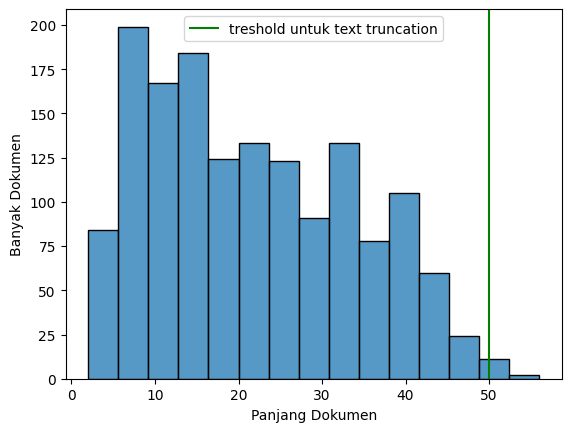

In [26]:
sns.histplot(train['text'].map(lambda x: len(x.split())))
plt.axvline(MAX_WORD, color='green', label='treshold untuk text truncation')
plt.legend()
plt.ylabel('Banyak Dokumen')
plt.xlabel('Panjang Dokumen')
plt.savefig('max_word.jpg')
print(f'Maksimal kata pada variabel text :', colored(train['text'].map(lambda x: len(x.split())).max(), 'green'))

### Positive and Negative Words

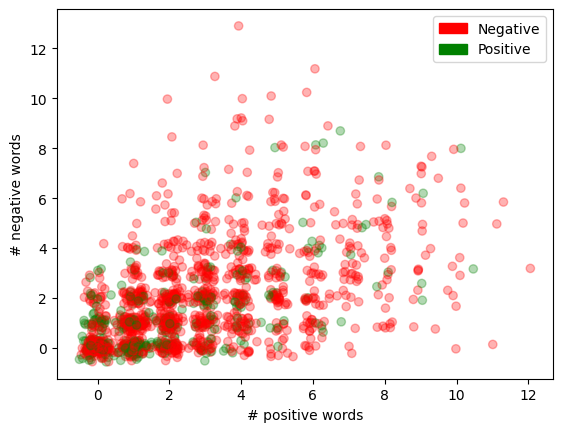

In [27]:
sentword_score = {}

def load_sentword(filename):
  file = open(get_path(filename), "r")
  file.readline()
  for line in file:
    word, score = line.strip().split("\t")
    score = int(score)
    sentword_score[word] = score
  file.close()

load_sentword("tools/negative.tsv")
load_sentword("tools/positive.tsv")

import matplotlib.patches as mpatches

num_pos = []
num_neg = []
scores  = []

for _, row in train.iterrows():
  tokens = row["text"].split()
  label = row[target.columns[0]]
  num_negative, num_positive = 0, 0

  for token in tokens:
    if token in sentword_score:
      if (sentword_score[token] < 0):
        num_negative += 1
      elif (sentword_score[token] > 0):
        num_positive += 1
  num_pos.append(num_positive)
  num_neg.append(num_negative)
  scores.append(label)

# # tambahkan kolom di dataframe
# train["pos_words"] = num_pos
# train["neg_words"] = num_neg

num_pos = np.array(num_pos)
num_neg = np.array(num_neg)
num_pos = num_pos + np.random.normal(0, 0.2, len(num_pos))
num_neg = num_neg + np.random.normal(0, 0.2, len(num_neg))

colors = ['g' if score == 1 else 'r' for score in scores]
plt.scatter(num_pos, num_neg, c = colors, alpha=0.3)
plt.xlabel('# positive words')
plt.ylabel('# negative words')

# Legend
red_patch = mpatches.Patch(color='red', label='Negative')
green_patch = mpatches.Patch(color='green', label='Positive')

plt.legend(handles=[red_patch, green_patch])
plt.savefig('pos_neg_word.jpg')
plt.show()

## Tabular

In [ ]:
def get_date_feature(df:pd.DataFrame, col:str) -> pd.DataFrame:
    df['year'] = df[col].dt.year
    df['month'] = df[col].dt.month
    df['week'] = np.int32(df[col].dt.isocalendar().week)
    df['weekday'] = df[col].dt.weekday
    df['quarter'] = df[col].dt.quarter
    df['day_of_year'] = df[col].dt.day_of_year
    df['day'] = df[col].dt.day
    df['day_of_week'] = df[col].dt.day_of_week
    return df

In [28]:
train.columns

Index(['created_at', 'id', 'user_id', 'user_name', 'url', 'text', 'media',
       'label'],
      dtype='object')

In [29]:
def get_positive_negative_word(df, is_train):
    def load_sentword(filename):
        file = open(get_path(filename), "r")
        file.readline()
        for line in file:
            word, score = line.strip().split("\t")
            score = int(score)
            sentword_score[word] = score
        file.close()

    load_sentword("tools/negative.tsv")
    load_sentword("tools/positive.tsv")

    num_pos = []
    num_neg = []
    tot_pos = []
    tot_neg = []

    if is_train:
        temp = train
    else:
        temp = test

    for _, row in temp.iterrows():
        tokens = row["text"].split()
        num_negative, num_positive, total_positive, total_negative = 0, 0, 0, 0

        for token in tokens:
            if token in sentword_score:
                if (sentword_score[token] < 0):
                    total_negative += sentword_score[token]
                    num_negative += 1
                    
                elif (sentword_score[token] > 0):
                    total_positive += sentword_score[token]
                    num_positive += 1
        num_pos.append(num_positive)
        num_neg.append(num_negative)
        tot_pos.append(total_positive)
        tot_neg.append(total_negative)

    # tambahkan kolom di dataframe
    df["pos_words"] = num_pos
    df["neg_words"] = num_neg
    df["sum_pos_words"] = tot_pos
    df["sum_neg_words"] = tot_neg
    return df

def get_tabular_dataset():
    """
        return:
            train
            test
            target
    """
    tabular_train = train.copy()
    tabular_test = test.copy()

    tabular_train = get_date_feature(tabular_train, 'created_at')
    tabular_test = get_date_feature(tabular_test, 'created_at')

    tabular_train = tabular_train.drop(['created_at', 'id', 'user_id', 'user_name', 'url', 'text', 'media', 'label'], axis=1)
    tabular_test = tabular_test.drop(['created_at', 'id', 'user_id', 'user_name', 'url', 'text', 'media'], axis=1)
    
    tabular_train = get_positive_negative_word(tabular_train, 1)
    tabular_test = get_positive_negative_word(tabular_test, 0)
    
    iklim = pd.read_csv(get_path('data/iklim_cleaned.csv'))

    tabular_train = pd.merge(tabular_train, iklim, left_on=['month', 'year'], right_on=['bulan', 'tahun'], validate='many_to_one')
    tabular_test = pd.merge(tabular_test, iklim, left_on=['month', 'year'], right_on=['bulan', 'tahun'], validate='many_to_one')
    return tabular_train, tabular_test, target.copy()

# Modelling

In [30]:
def f1_loss(y_true, y_pred):
    """
        f1 differentiable for loss function 
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    return 2 * (precision * recall) / (precision+recall + K.epsilon())
import tensorflow as tf
import keras
from keras import layers, activations, losses, optimizers, initializers, regularizers, metrics, Input, models
import sklearn.metrics as skMetrics
from sklearn.model_selection import train_test_split

def plot_hist(hist):
    """
        Hist TF .fit Visualization for parameter finding
    """
    fig = plt.figure()
    fig.add_subplot(1, 2, 1)
    plt.plot(hist.history['acc'], label = 'train')
    plt.plot(hist.history['val_acc'], label = 'validation')
    plt.xlabel('acc')
    plt.legend()
    fig.add_subplot(1, 2, 2)
    plt.plot(hist.history['mae'], label = 'train')
    plt.plot(hist.history['val_mae'], label = 'validation')
    plt.xlabel('mae')
    plt.legend()

## Text Model Preparation

In [31]:
tokenizer = AutoTokenizer.from_pretrained("indolem/indobertweet-base-uncased")
bert_model = TFBertModel.from_pretrained("indolem/indobertweet-base-uncased", \
                                         output_attentions=True, \
                                         from_pt = True)

def bert_tokenize(documents, is_tuple = False):
  if not is_tuple:
    tokenized = tokenizer(documents, padding='max_length', max_length=MAX_WORD, truncation=True)
  else:
    tokenized = tokenizer(documents[0], documents[1], padding='max_length', max_length=MAX_WORD, truncation=True)
  ids = np.array(tokenized['input_ids'])
  ams = np.array(tokenized['token_type_ids'])
  msk = np.array(tokenized['attention_mask'])
  return ids, ams, msk
clear_output()

## Machine Learning Finishing Model

In [32]:
################################################ Text model ################################################
input_ids_layer = tf.keras.layers.Input(shape=(MAX_WORD,), 
                                        name='input_ids', 
                                        dtype='int32')
input_attention_mask = tf.keras.layers.Input(shape=(MAX_WORD,), 
                                             name='input_attention_mask', 
                                             dtype='int32')
input_type_ids = tf.keras.layers.Input(shape=(MAX_WORD,), 
                                       name='input_type_ids', 
                                       dtype='int32')
last_hidden_state = bert_model([input_ids_layer, input_attention_mask, input_type_ids]).last_hidden_state
for layer in bert_model.layers:
    layer.trainable = False
cls_last_output = last_hidden_state[:, 0, :]
dense_t_1 = layers.Dense(450, activation='relu', kernel_initializer = tf.keras.initializers.GlorotNormal(seed = 42),bias_initializer = 'zeros',
                                   kernel_regularizer = tf.keras.regularizers.L1(l1=1e-3),
                                   bias_regularizer = tf.keras.regularizers.L1(1e-3))(cls_last_output)
dropout_t_1 = layers.Dropout(.5)(dense_t_1)
output_text = tf.keras.layers.Dense(1, 
                              activation = 'sigmoid',
                              bias_initializer = 'zeros',
                              name = 'dense_classifier')(dropout_t_1)
####
text_model = tf.keras.Model([input_ids_layer, input_attention_mask, input_type_ids], output_text)
text_model.compile('adam', 
              loss = losses.BinaryCrossentropy(),
              metrics = [f1_loss, 'acc', 'mae'])
##############################################################################################################

################################################ Image Model #################################################
from keras.applications import EfficientNetB2
from keras.applications.efficientnet import preprocess_input

input_img = Input(shape=IMG_SHAPE, dtype=tf.float32)
efficientNetB7_layer = EfficientNetB2()(preprocess_input(input_img))
efficientNetB7_layer.trainable = False
flatten_layer = layers.Flatten()(efficientNetB7_layer)
dense_layer = layers.Dense(300, activation='relu', kernel_initializer = tf.keras.initializers.GlorotNormal(seed = 42), bias_initializer = 'zeros',
                                   kernel_regularizer = tf.keras.regularizers.L1(l1=1e-3),
                                   bias_regularizer = tf.keras.regularizers.L1(1e-3))(flatten_layer)
dropout_layer = layers.Dropout(.5)(dense_layer)
output_img = tf.keras.layers.Dense(1, activation = 'sigmoid')(dropout_layer)
####
img_model = tf.keras.Model(input_img, output_img)
img_model.compile('adam', loss = losses.BinaryCrossentropy(), metrics = [f1_loss, 'acc', 'mae'])
##############################################################################################################

############################################# Concat with tabular ############################################
tbr_train, test_tbr, _ = get_tabular_dataset()
train_img, test_img, target = get_image_dataset()
train_text, test_text, target = get_text_dataset()

train_text, val_text, train_y, val_y, train_tbr, val_tbr, train_img, val_img  = train_test_split(train_text, target, tbr_train, train_img, test_size=.2, stratify=target)

train_ids, train_ams, train_msk = bert_tokenize(list(train_text))
val_ids, val_ams, val_msk = bert_tokenize(list(val_text))
test_ids, test_ams, test_msk = bert_tokenize(list(test_text))
##############################################################################################################

In [162]:
from keras import callbacks
val_mae_earlystopping = callbacks.EarlyStopping('val_f1_score', patience=30, mode='max', restore_best_weights=True)
hist = text_model.fit(
    x = [train_ids, train_ams, train_msk],
    y = tf.cast(train_y, tf.float32),
    epochs = 300,
    batch_size = 32,
    validation_data = ([val_ids, val_ams, val_msk], tf.cast(val_y, tf.float32)),
    callbacks=[val_mae_earlystopping]
)
hist2 = img_model.fit(
    x = train_img,
    y = tf.cast(train_y, tf.float32),
    epochs = 300,
    batch_size = 32,
    validation_data = (val_img, tf.cast(val_y, tf.float32)),
    callbacks=[val_mae_earlystopping]
)
clear_output()

In [163]:
print('IMG Model')
print(f"{colored('Training F1 :', 'cyan')}\t", skMetrics.f1_score(train_y, [int(x>.5) for x in img_model.predict(train_img, verbose=0)]))
print(f"{colored('Validation F1 :', 'red')}\t", skMetrics.f1_score(val_y, [int(x>.5) for x in img_model.predict(val_img, verbose=0)]))
print('TXT Model')
print(f"{colored('Training F1 :', 'cyan')}\t", skMetrics.f1_score(train_y, [int(x>.5) for x in text_model.predict([train_ids, train_ams, train_msk], verbose=0)]))
print(f"{colored('Validation F1 :', 'red')}\t", skMetrics.f1_score(val_y, [int(x>.5) for x in text_model.predict([val_ids, val_ams, val_msk], verbose=0)]))

IMG Model
Training F1 :	 0.902654867256637
Validation F1 :	 0.624113475177305
TXT Model
Training F1 :	 0.6918238993710691
Validation F1 :	 0.6545454545454545


In [164]:
train_tbr['imgPred'] = img_model.predict(train_img, verbose = 0)
val_tbr['imgPred'] = img_model.predict(val_img, verbose = 0)
test_tbr['imgPred'] = img_model.predict(test_img, verbose = 0)

train_tbr['textPred'] = text_model.predict([train_ids, train_ams, train_msk], verbose = 0)
val_tbr['textPred'] = text_model.predict([val_ids, val_ams, val_msk], verbose = 0)
test_tbr['textPred'] = text_model.predict([test_ids, test_ams, test_msk], verbose = 0)

In [165]:
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

final_model = XGBClassifier(
    n_estimators = 1000,
    # max_depth=5
    learning_rate= 0.001,
    tree_method = 'gpu_hist'
)
final_model.fit(train_tbr, train_y)
clear_output()
print(f"{colored('Training F1 :', 'cyan')}\t", skMetrics.f1_score(train_y, [int(x>.5) for x in final_model.predict(train_tbr)]))
print(f"{colored('Validation F1 :', 'red')}\t", skMetrics.f1_score(val_y, [int(x>.5) for x in final_model.predict(val_tbr)]))

Training F1 :	 0.9530956848030019
Validation F1 :	 0.6875


In [ ]:
try:
    plt.barh(final_model.feature_names_in_, final_model.feature_importances_)
except AttributeError:
    print('No feature importance found')

In [166]:
pred = final_model.predict(test_tbr[train_tbr.columns])
output = pd.DataFrame()
output['id'] = test.id
output['label'] = pred
output

,id,label
0,1213309429254250496,0
1,1216196702647939072,0
2,1216296533735309312,0
3,1234385081482956800,0
4,1214853229567041537,0
...,...,...
1006,1212371781350084608,0
1007,1232075152042541056,1
1008,1213315563595845633,0
1009,1212970781610663936,0


In [167]:
output['label'].value_counts()

0    803
1    208
Name: label, dtype: int64

In [168]:
output.to_csv('95_69.csv', index=False)